## Packages

In [3]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima.arima import auto_arima
!pip install arch
from arch import arch_model
!pip install yfinance
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.4 MB 3.6 MB/s 
     |████████████████████████████████| 9.8 MB 40.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


     |████████████████████████████████| 899 kB 4.2 MB/s 
     |████████████████████████████████| 6.3 MB 5.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=dfb604feaca46d8af1b6d4d0377add0701cb27c34d87185c0cd0102f696ef711
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Loading the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
raw_csv_data = pd.read_excel("/content/drive/MyDrive/Index3 excel.xlsx",header=2)
df_comp=raw_csv_data.copy()


df_comp.date = pd.to_datetime(df_comp.Date, dayfirst = True)
df_comp.set_index("Date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')
df_comp.head()

df_comp['IPC']=df_comp.Close


## Creating Returns

In [6]:
df_comp['ret_IPC'] = df_comp.IPC.pct_change(1).mul(100)
df_comp.head()

,Close,IPC,ret_IPC
Date,,,
2021-01-04,44703.00,44703.00,NaN
2021-01-05,44908.12,44908.12,0.458851
2021-01-06,45587.16,45587.16,1.512065
2021-01-07,46188.66,46188.66,1.319450
2021-01-08,46729.30,46729.30,1.170504


In [7]:
df_comp['norm_ret_IPC'] = df_comp.ret_IPC.div(df_comp.IPC[1])*100
df_comp.head()

,Close,IPC,ret_IPC,norm_ret_IPC
Date,,,,
2021-01-04,44703.00,44703.00,NaN,NaN
2021-01-05,44908.12,44908.12,0.458851,0.001022
2021-01-06,45587.16,45587.16,1.512065,0.003367
2021-01-07,46188.66,46188.66,1.319450,0.002938
2021-01-08,46729.30,46729.30,1.170504,0.002606


## Splitting the Data

In [8]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]
df_test.head()
df.head()

,Close,IPC,ret_IPC,norm_ret_IPC
Date,,,,
2021-01-04,44703.00,44703.00,NaN,NaN
2021-01-05,44908.12,44908.12,0.458851,0.001022
2021-01-06,45587.16,45587.16,1.512065,0.003367
2021-01-07,46188.66,46188.66,1.319450,0.002938
2021-01-08,46729.30,46729.30,1.170504,0.002606


In [9]:
df.tail()

,Close,IPC,ret_IPC,norm_ret_IPC
Date,,,,
2021-08-19,51099.36,51099.36,-1.705687,-0.003798
2021-08-20,51414.32,51414.32,0.616368,0.001373
2021-08-23,52054.64,52054.64,1.245412,0.002773
2021-08-24,51985.00,51985.00,-0.133783,-0.000298
2021-08-25,52345.39,52345.39,0.693258,0.001544


In [10]:
df_test.head()

,Close,IPC,ret_IPC,norm_ret_IPC
Date,,,,
2021-08-26,52290.69,52290.69,-0.104498,-0.000233
2021-08-27,52425.64,52425.64,0.258077,0.000575
2021-08-30,52602.07,52602.07,0.336534,0.000749
2021-08-31,53304.74,53304.74,1.335822,0.002975
2021-09-01,52215.54,52215.54,-2.043345,-0.004550


In [11]:
df_test.tail()

,Close,IPC,ret_IPC,norm_ret_IPC
Date,,,,
2021-10-18,52686.03,52686.03,-0.212791,-0.000474
2021-10-19,52402.73,52402.73,-0.537714,-0.001197
2021-10-20,52298.20,52298.20,-0.199474,-0.000444
2021-10-21,52020.05,52020.05,-0.531854,-0.001184
2021-10-22,51889.66,51889.66,-0.250653,-0.000558


## Fitting a Model

In [12]:
model_ar = ARIMA(df.IPC, order = (1,0,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    IPC   No. Observations:                  168
Model:                     ARMA(1, 0)   Log Likelihood               -1261.756
Method:                       css-mle   S.D. of innovations            437.066
Date:                Thu, 11 Nov 2021   AIC                           2529.512
Time:                        23:08:41   BIC                           2538.884
Sample:                    01-04-2021   HQIC                          2533.315
                         - 08-25-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.84e+04   2158.646     22.422      0.000    4.42e+04    5.26e+04
ar.L1.IPC      0.9892      0.010     94.822      0.000       0.969       1.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0109           +0.0000j            1.0109            0.0000
-----------------------------------------------------------------------------
"""

## Simple Forecasting

In [13]:
df.tail()

,Close,IPC,ret_IPC,norm_ret_IPC
Date,,,,
2021-08-19,51099.36,51099.36,-1.705687,-0.003798
2021-08-20,51414.32,51414.32,0.616368,0.001373
2021-08-23,52054.64,52054.64,1.245412,0.002773
2021-08-24,51985.00,51985.00,-0.133783,-0.000298
2021-08-25,52345.39,52345.39,0.693258,0.001544


In [14]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2021-08-26"
end_date = "2021-10-22"

In [15]:
df_pred = results_ar.predict(start = start_date, end = end_date)

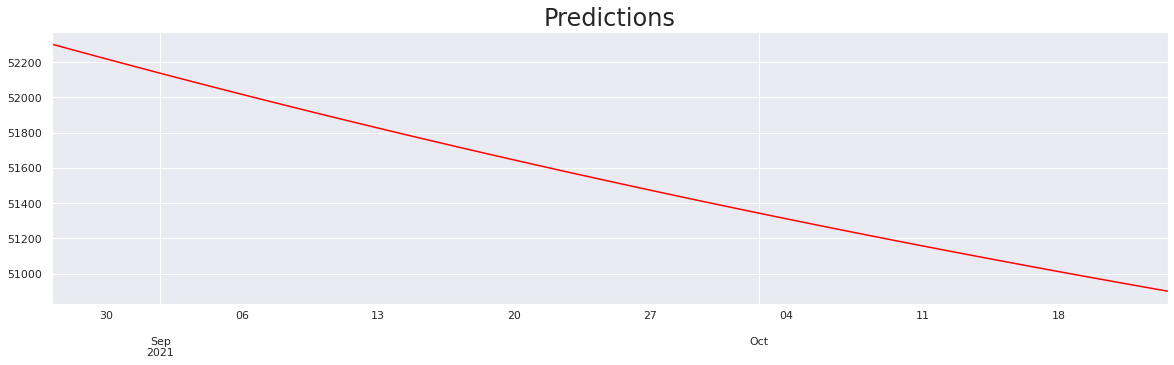

In [16]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("Predictions", size = 24)
plt.show()

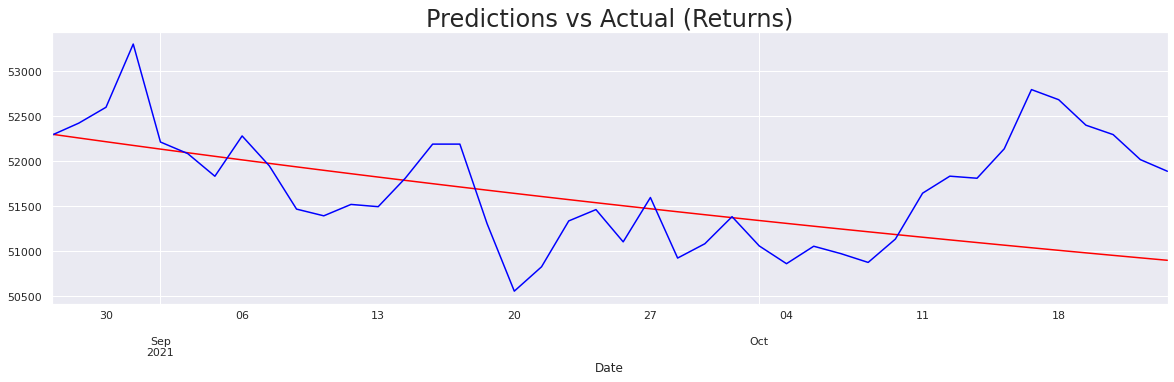

In [17]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.IPC[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### Using Returns Instead

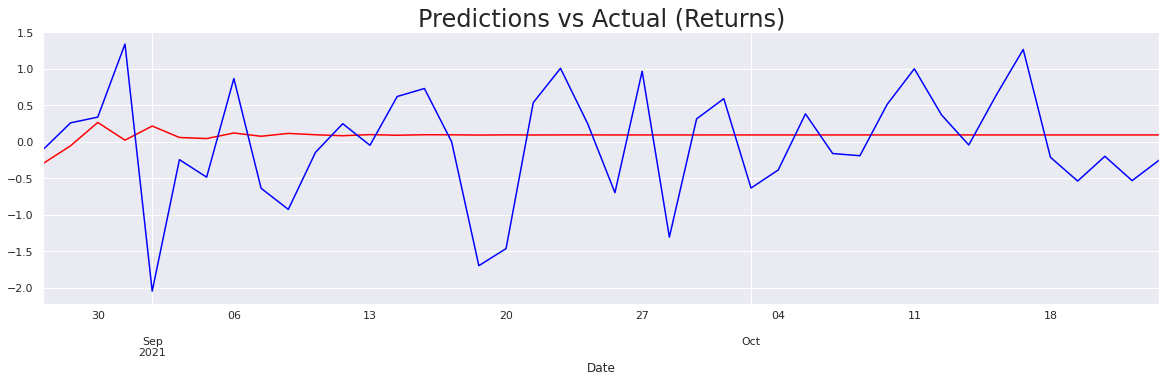

In [19]:
start_date = "2021-08-26"
end_date = "2021-10-22"


model_ret_ar = ARIMA(df.ret_IPC[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_IPC[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [ ]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       ret_market_value   No. Observations:                  167
Model:                     ARMA(5, 0)   Log Likelihood                -216.740
Method:                       css-mle   S.D. of innovations              0.885
Date:                Tue, 09 Nov 2021   AIC                            447.481
Time:                        02:11:24   BIC                            469.307
Sample:                    01-05-2021   HQIC                           456.340
                         - 08-25-2021                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0930      0.053      1.768      0.079      -0.010       0.196
ar.L1.ret_market_value    -0.0549      0.077     -0.714      0.476      -0.206       0.096
ar.L2.ret_market_value    -0.1287      0.077     -1.676      0.096      -0.279       0.022
ar.L3.ret_market_value    -0.0885      0.078     -1.139      0.256      -0.241       0.064
ar.L4.ret_market_value    -0.1494      0.078     -1.924      0.056      -0.302       0.003
ar.L5.ret_market_value     0.1141      0.079      1.448      0.150      -0.040       0.269
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0743           -0.8921j            1.3965           -0.3897
AR.2           -1.0743           +0.8921j            1.3965            0.3897
AR.3            0.6013           -1.2771j            1.4116           -0.1800
AR.4            0.6013           +1.2771j            1.4116            0.1800
AR.5            2.2558           -0.0000j            2.2558           -0.0000
-----------------------------------------------------------------------------
"""

### MA

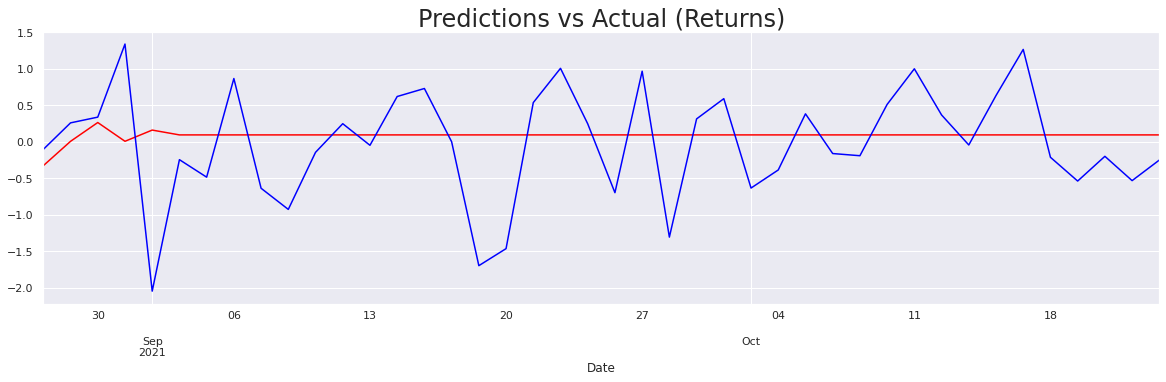

In [65]:
end_date = "2021-10-22"

model_ret_ma = ARIMA(df.ret_IPC[1:], order=(0,0,5))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_IPC[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [25]:
results_ret_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                ret_IPC   No. Observations:                  167
Model:                     ARMA(0, 1)   Log Likelihood                -221.555
Method:                       css-mle   S.D. of innovations              0.912
Date:                Thu, 11 Nov 2021   AIC                            449.111
Time:                        23:22:44   BIC                            458.465
Sample:                    01-05-2021   HQIC                           452.907
                         - 08-25-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0984      0.067      1.471      0.143      -0.033       0.230
ma.L1.ret_IPC    -0.0523      0.089     -0.587      0.558      -0.227       0.122
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           19.1268           +0.0000j           19.1268            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
df_pred_ma.head()

2021-08-26   -0.327497
2021-08-27    0.005655
2021-08-30    0.262718
2021-08-31    0.006088
2021-09-01    0.159365
Freq: B, dtype: float64

### ARMA

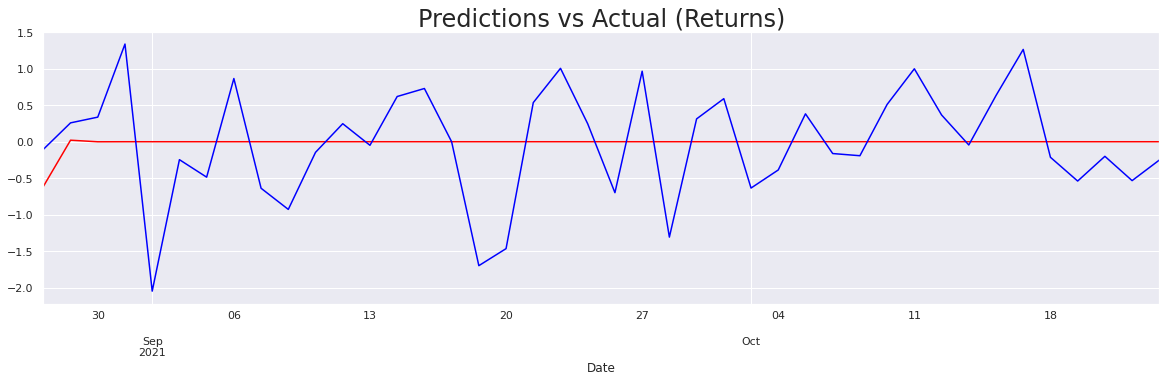

In [66]:
model_ret_arma = ARIMA(df.ret_IPC[1:], order=(1,1,1))

results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_IPC[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()


In [ ]:
df_pred_arma.head()

2014-07-16    0.051210
2014-07-17    0.043852
2014-07-18    0.038185
2014-07-21    0.033818
2014-07-22    0.030455
Freq: B, dtype: float64

In [ ]:
df_pred_arma.tail()

2014-12-26    0.019172
2014-12-29    0.019172
2014-12-30    0.019172
2014-12-31    0.019172
2015-01-01    0.019172
Freq: B, dtype: float64

### ARMAX

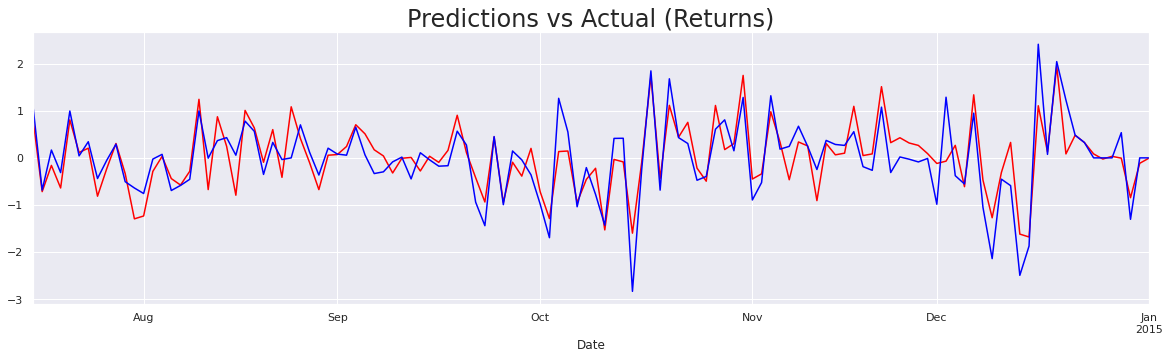

In [ ]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARMA

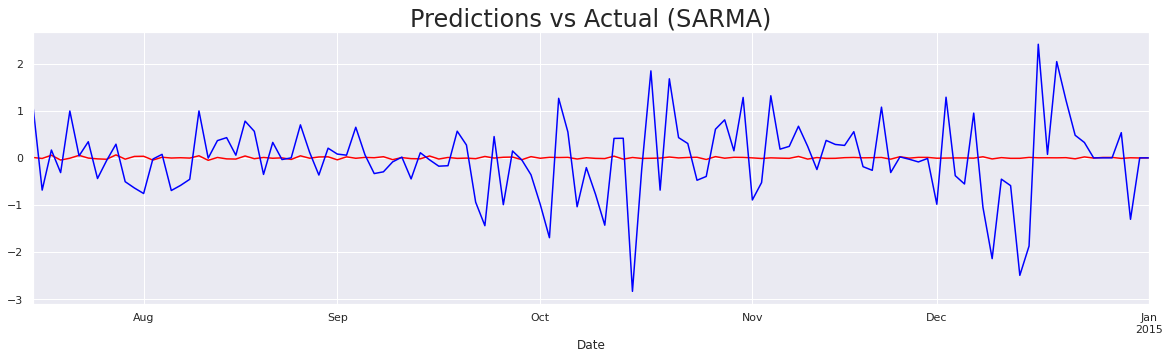

In [ ]:
end_date = "2015-01-01"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

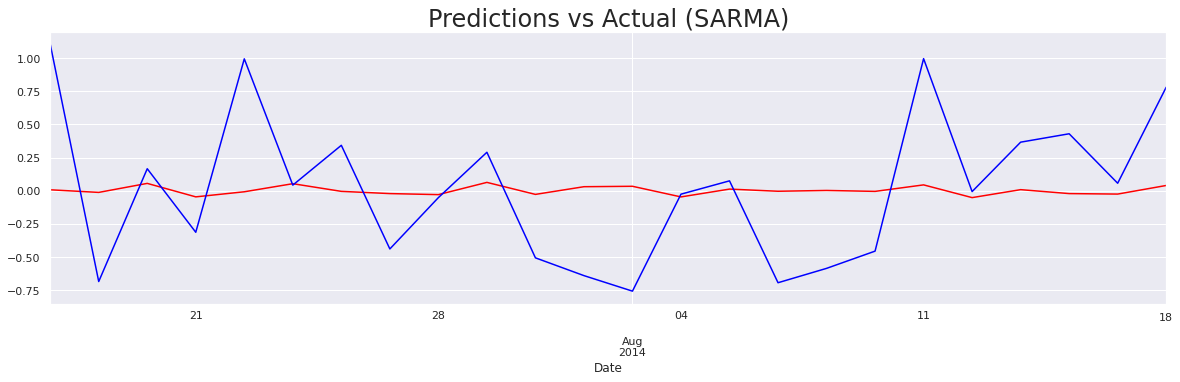

In [ ]:
end_date = "2014-08-18"

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

### SARIMAX

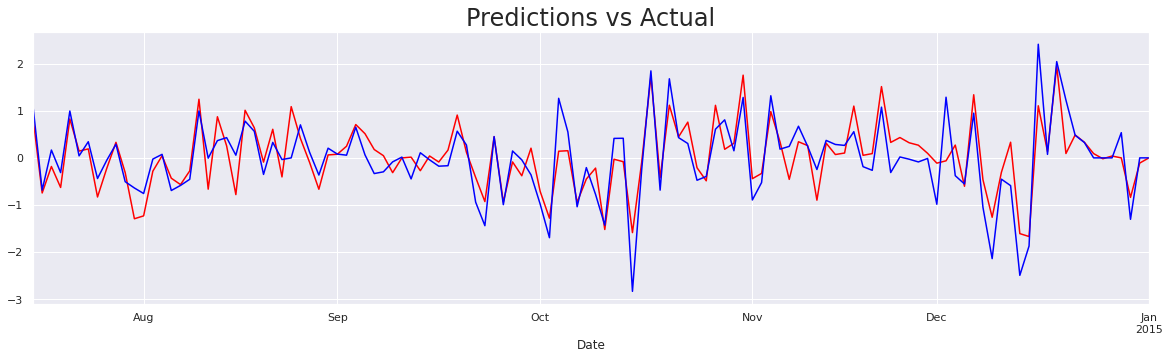

In [ ]:
end_date = "2015-01-01"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA

In [43]:
model_auto0 = auto_arima(df.ret_IPC[1:], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [44]:
df_auto_pred0 = pd.DataFrame(model_auto0.predict(n_periods = len(df_test[start_date:end_date])), index = df_test[start_date:end_date].index)

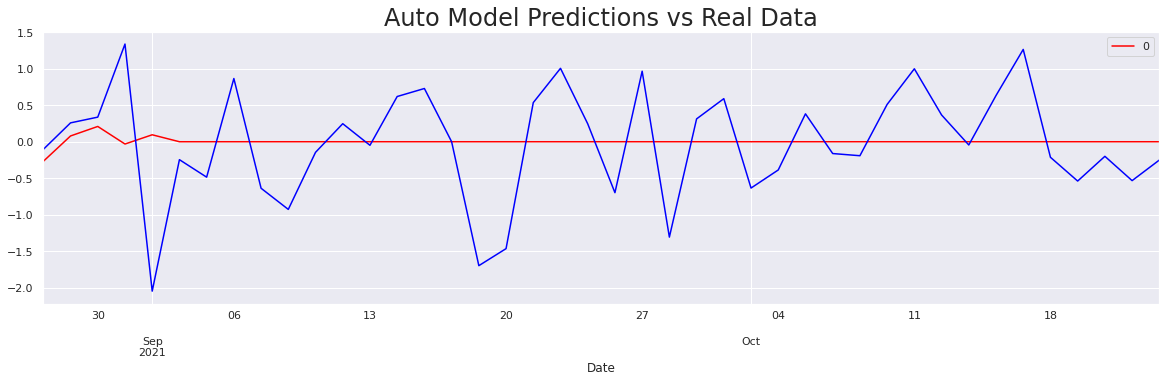

In [45]:
df_auto_pred0.plot(figsize = (20,5), color = "red")
df_test.ret_IPC[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [48]:
model_auto = auto_arima(df.ret_IPC[1:], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)
# exogenous = df[['ret_spx', 'ret_dax'," 'ret_nikkei']][1:]

In [68]:
df_auto_pred = pd.DataFrame(model_auto0.predict(n_periods = len(df_test[start_date:end_date])), index = df_test[start_date:end_date].index)
# exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]

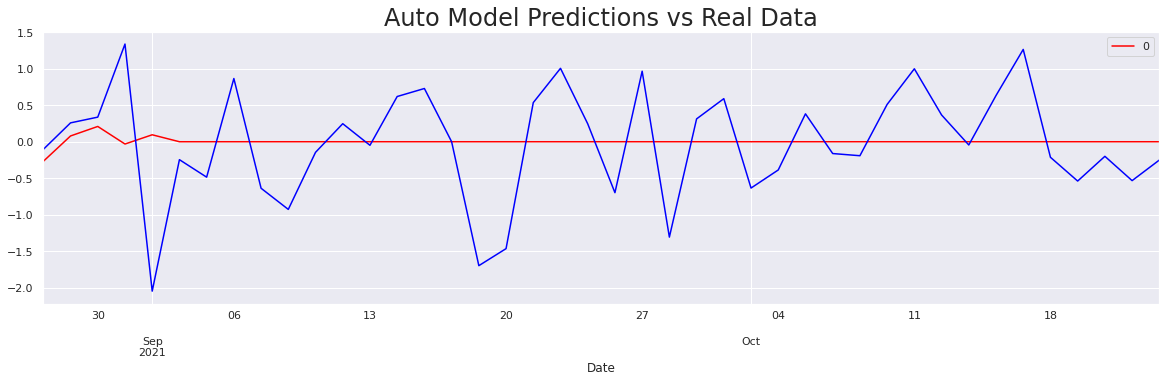

In [70]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_IPC[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Comparing All the Models (Returns)

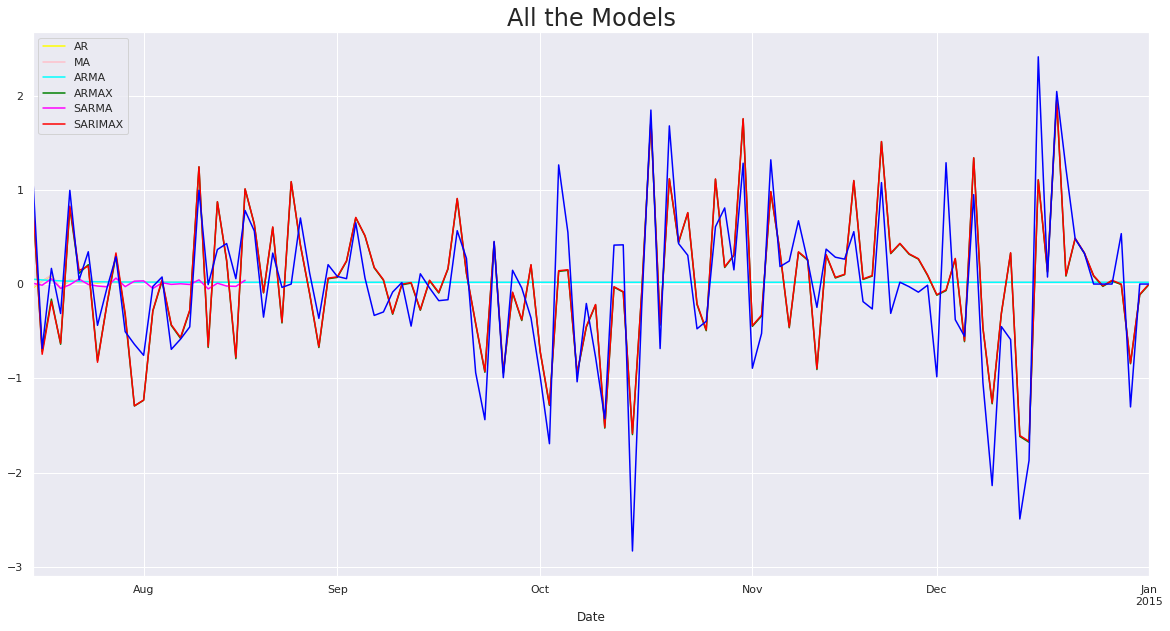

In [ ]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volatility

In [71]:
mod_garch = arch_model(df_comp.ret_IPC[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     67,   Neg. LLF: 219.27756163124553
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 219.27753777409612
            Iterations: 11
            Function evaluations: 73
            Gradient evaluations: 11


In [72]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

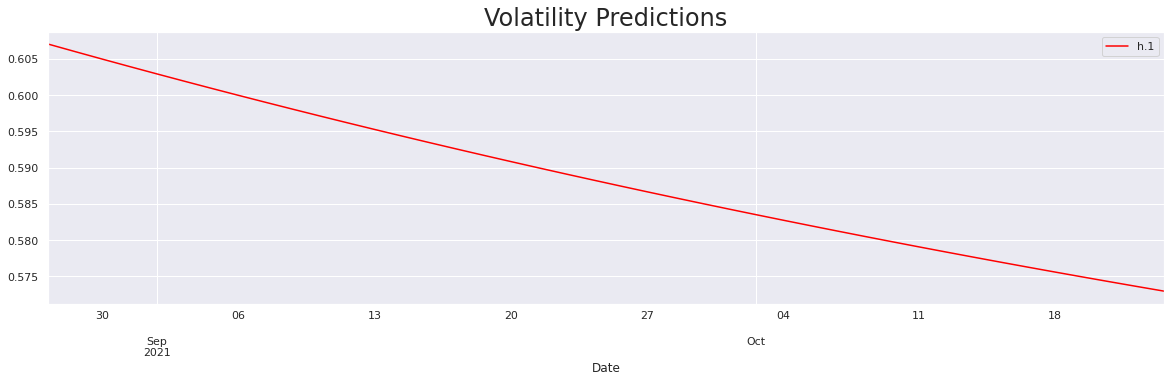

In [73]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
plt.title("Volatility Predictions", size = 24)
plt.show()

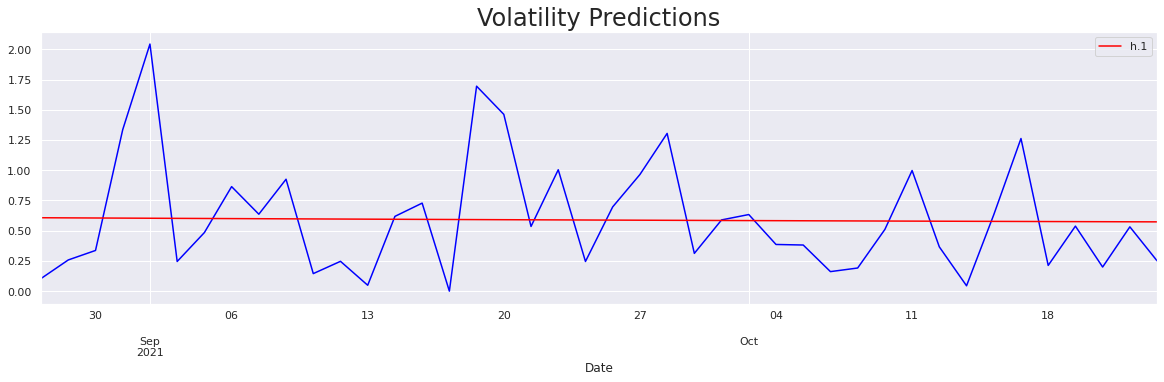

In [74]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_IPC.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [ ]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,h.011,h.012,h.013,h.014,h.015,h.016,h.017,h.018,h.019,h.020,h.021,h.022,h.023,h.024,h.025,h.026,h.027,h.028,h.029,h.030,h.031,h.032,h.033,h.034,h.035,h.036,h.037,h.038,h.039,h.040,...,h.061,h.062,h.063,h.064,h.065,h.066,h.067,h.068,h.069,h.070,h.071,h.072,h.073,h.074,h.075,h.076,h.077,h.078,h.079,h.080,h.081,h.082,h.083,h.084,h.085,h.086,h.087,h.088,h.089,h.090,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811449,0.805648,0.867232,0.940608,1.02073,1.084989,1.074064,1.067783,1.08121,1.090608,1.142407,1.121338,1.036393,1.11072,1.183629,1.257723,1.248608,1.336788,1.395024,1.014502,0.65149,0.691586,0.683082,0.701209,0.509165,0.491619,0.510821,0.490371,0.49208,0.512208,0.531597,0.528003,0.524606,0.523109,0.536405,0.555709,0.569648,0.590162,0.609764,0.63289,...,0.779928,0.790801,0.816335,0.836243,0.860533,0.85355,0.873285,0.827,0.8511,0.878126,0.888177,0.808246,0.829919,0.85095,0.859692,0.883821,0.883548,0.883613,0.855375,0.8605,0.882306,0.865465,0.886742,0.777604,0.790476,0.798239,0.800314,0.802961,0.810827,0.823701,0.837281,0.838888,0.830292,0.815455,0.827095,0.839331,0.850645,0.864163,0.871725,0.886197


### Multivariate Regression Model

In [79]:
from statsmodels.tsa.api import VAR

In [90]:
df_ret = df['ret_IPC'][1:]

In [91]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

ValueError: ignored

In [ ]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 25, Apr, 2020
Time:                     07:48:55
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.330716
Nobs:                     5346.00    HQIC:                  0.263399
Log likelihood:          -30866.1    FPE:                    1.25516
AIC:                     0.227263    Det(Omega_mle):         1.23563
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039150         0.016160            2.423           0.015
L1.ret_spx           -0.110568         0.017558           -6.297           0.000
L1.ret_dax            0.065289         0.019034           

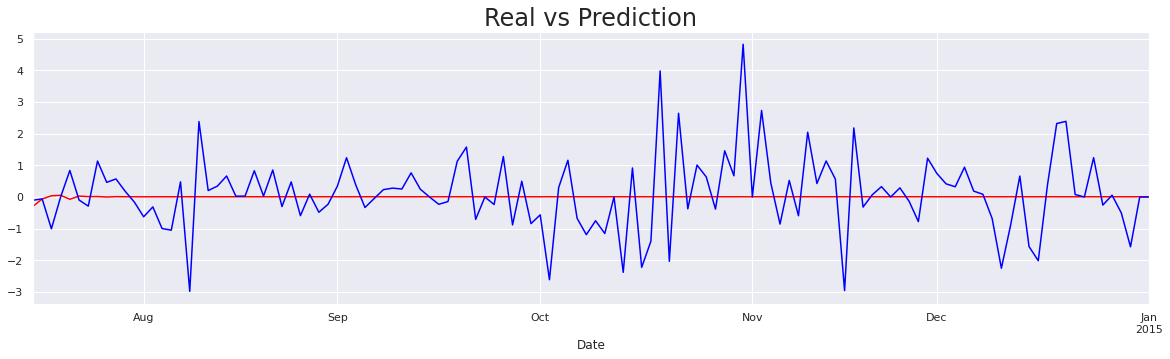

In [ ]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

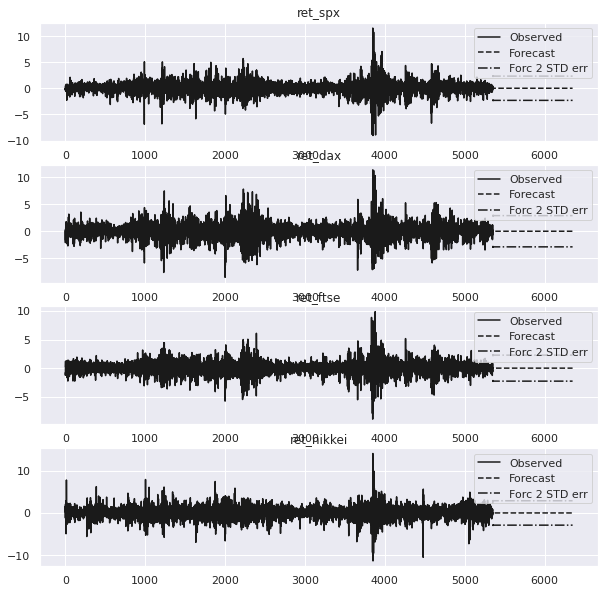

In [ ]:
results_var_ret.plot_forecast(1000)
plt.show()